# Applied Data Science: Assignment 1
#### By Jeremy Lau

In [1]:
import os

def get_project_path(relative_path):
    # Get the directory where this script is located
    script_dir = os.path.dirname(os.path.abspath(__file__))
    # Join it with the relative path to get the full path
    return os.path.join(script_dir, relative_path)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("TaxiDataAnalysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.extraLibraryPath", "/path/to/hadoop/lib/native")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/30 17:22:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Landing Layer

#### Reading in Taxi Data

In [3]:
df_yellow_1 = spark.read.parquet("../data/Landing Layer/Yellow Taxi/2024-01.parquet")
df_yellow_2 = spark.read.parquet("../data/Landing Layer/Yellow Taxi/2024-02.parquet")
df_yellow_3 = spark.read.parquet("../data/Landing Layer/Yellow Taxi/2024-03.parquet")
df_yellow_4 = spark.read.parquet("../data/Landing Layer/Yellow Taxi/2024-04.parquet")
df_yellow_5 = spark.read.parquet("../data/Landing Layer/Yellow Taxi/2024-05.parquet")
df_yellow_12 = spark.read.parquet("../data/Landing Layer/Yellow Taxi/2023-12.parquet")
df_yellow_1.show(1)
df_yellow_1.count()
#df_yellow_1.printSchema()


df1 = df_yellow_1.count()
df2 = df_yellow_2.count()
df3 = df_yellow_3.count()
df4 = df_yellow_4.count()
df5 = df_yellow_5.count()
df12 = df_yellow_12.count()

total_rows = df1 + df2 + df3 + df4 + df5 + df12
print(total_rows)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|           2|       17.7|  1.0|    0.5|       0.

## Raw Layer
#### Process: Remove Null Rows -> Remove Negative Values -> Combine Taxi datasets -> Remove Duplicates

#### Removing rows with missing values

In [4]:
# Remove rows with all missing values
df_yellow_no_nulls_1 = df_yellow_1.na.drop(how="all")
df_yellow_no_nulls_2 = df_yellow_2.na.drop(how="all")
df_yellow_no_nulls_3 = df_yellow_3.na.drop(how="all")
df_yellow_no_nulls_4 = df_yellow_4.na.drop(how="all")
df_yellow_no_nulls_5 = df_yellow_5.na.drop(how="all")
df_yellow_no_nulls_12 = df_yellow_12.na.drop(how="all")

In [5]:
df1 = df_yellow_no_nulls_1.count()
df2 = df_yellow_no_nulls_2.count()
df3 = df_yellow_no_nulls_3.count()
df4 = df_yellow_no_nulls_4.count()
df5 = df_yellow_no_nulls_5.count()
df12 = df_yellow_no_nulls_12.count()

total_rows = df1 + df2 + df3 + df4 + df5 + df12
print(total_rows)

24/08/30 16:32:46 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


20169467


#### Removing negative value rows

In [6]:
# List of columns to filter
columns_to_check = ['trip_distance', 
                    'fare_amount', 
                    'total_amount', 
                    'passenger_count', 
                    'extra', 
                    'mta_tax', 
                    'tip_amount', 
                    'tolls_amount', 
                    'improvement_surcharge', 
                    'congestion_surcharge', 
                    'Airport_fee']

# Create filter conditions using the `reduce` function
from functools import reduce

non_negative_filter = reduce(lambda acc, col_name: acc & (col(col_name) >= 0), 
                             columns_to_check, 
                             col(columns_to_check[0]) >= 0)

# Apply the filter to remove rows with negative values
df_yellow_filtered_1 = df_yellow_no_nulls_1.filter(non_negative_filter)
df_yellow_filtered_2 = df_yellow_no_nulls_2.filter(non_negative_filter)
df_yellow_filtered_3 = df_yellow_no_nulls_3.filter(non_negative_filter)
df_yellow_filtered_4 = df_yellow_no_nulls_4.filter(non_negative_filter)
df_yellow_filtered_5 = df_yellow_no_nulls_5.filter(non_negative_filter)
df_yellow_filtered_12 = df_yellow_no_nulls_12.filter(non_negative_filter)

# Note: While filtering, passenger_count, ratecodeID, store_and_fwd_flag, congestion_surcharge and airport_fee all have 140162 null rows in Jan dataset. 
# Try explain in dataset analysis

# Verify the results

"""df_yellow_filtered_1.describe(columns_to_check).show()
print(df_yellow_12.count())
print(df_yellow_no_nulls_12.count()) 
print(df_yellow_filtered_12.count()) """

'df_yellow_filtered_1.describe(columns_to_check).show()\nprint(df_yellow_12.count())\nprint(df_yellow_no_nulls_12.count()) \nprint(df_yellow_filtered_12.count()) '

#### Combining 6 months of taxi data into 1 dataset

In [7]:
# Combining 6 months of yellow taxi data into 1 dataset
from functools import reduce

dfs = [df_yellow_filtered_1, df_yellow_filtered_2, df_yellow_filtered_3, df_yellow_filtered_4, df_yellow_filtered_5, df_yellow_filtered_12]  # List of DataFrames
df_yellow_filtered = reduce(lambda df_yellow_filtered_1, df_yellow_filtered_2: df_yellow_filtered_1.union(df_yellow_filtered_2), dfs)
df_yellow_filtered.count()


18175759

In [8]:
#RateodeID and Payment_type between 1 and 6
#Mta_tax is 0.5 as per dataset description

# Filter out rows where RatecodeID is not in the specified list
df_yellow_filtered = df_yellow_filtered.filter(col("RatecodeID").isin(1, 2, 3, 4, 5, 6))
df_yellow_filtered = df_yellow_filtered.filter(col("Payment_type").isin(1, 2, 3, 4, 5, 6))
df_yellow_filtered = df_yellow_filtered.filter(col("mta_tax").isin(0.5))


# Filter out rows based on conditions for trip_distance and fare_amount
df_yellow_filtered = df_yellow_filtered.filter(
    (col("trip_distance") >= 0.25) &
    (col("fare_amount") >= 3)
)

# Verify the results
df_yellow_filtered.show()

df_yellow_filtered.describe(['trip_distance', 
                    'fare_amount', 
                    'total_amount', 
                    'passenger_count', 
                    'extra', 
                    'mta_tax', 
                    'tip_amount', 
                    'tolls_amount', 
                    'improvement_surcharge', 
                    'congestion_surcharge', 
                    'Airport_fee']).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|           2|       17.7|  1.0|    0.5|       0.

24/08/30 16:33:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+---------------------+--------------------+------------------+
|summary|     trip_distance|       fare_amount|     total_amount|   passenger_count|             extra|             mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|congestion_surcharge|       Airport_fee|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+---------------------+--------------------+------------------+
|  count|          17513231|          17513231|         17513231|          17513231|          17513231|            17513231|          17513231|          17513231|             17513231|            17513231|          17513231|
|   mean|3.2711716473104557| 18.64450771990735|27.79259532981388| 1.347006272000866|1.61926872203078

In [9]:
df_yellow_filtered.count()

17513231

In [10]:
# Converting date time into ISO 8601 format

# Convert tpep_dropoff_datetime to ISO 8601 format (YYYY-MM-DDTHH:mm:ss)
df_yellow_filtered = df_yellow_filtered.withColumn("tpep_dropoff_datetime", date_format(col("tpep_dropoff_datetime"), "yyyy-MM-dd'T'HH:mm:ss"))
df_yellow_filtered = df_yellow_filtered.withColumn("tpep_pickup_datetime", date_format(col("tpep_pickup_datetime"), "yyyy-MM-dd'T'HH:mm:ss"))

# Renaming columns to pickup_datetime and dropoff_datetime
df_yellow_filtered_renamed = df_yellow_filtered.withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime")
df_yellow_filtered_renamed = df_yellow_filtered_renamed.withColumnRenamed("tpep_pickup_datetime", "pickup_datetime")

In [11]:
#Save the filtered raw data to a Parquet file
df_yellow_filtered_renamed.write.mode('overwrite').parquet('../data/Raw Layer/yellow_filtered.parquet')

24/08/30 16:33:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/30 16:33:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/30 16:33:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/30 16:33:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/30 16:33:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/30 16:33:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/30 16:33:54 WARN MemoryManager: Total allocation exceeds 95.00% 

## Curated Layer
#### Remove Taxi PU or DO that are outside NYC -> Removing Outliers from all columns -> Spatial Join with Ticket Dataset

In [16]:
df_yellow_filtered = spark.read.parquet("../data/Raw Layer/yellow_filtered.parquet")
df_yellow_filtered.show()

+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2|2023-12-09T20:23:14|2023-12-09T20:41:22|              1|         1.31|         1|                 N|          48|         237|           1|       16.3|  1.0|    0.5|       2.0|         0

In [17]:
# Check for outliers in numerical columns
df_yellow_filtered.describe(['trip_distance', 
                    'fare_amount', 
                    'total_amount', 
                    'passenger_count', 
                    'extra', 
                    'mta_tax', 
                    'tip_amount', 
                    'tolls_amount', 
                    'improvement_surcharge', 
                    'congestion_surcharge', 
                    'Airport_fee']).show()

df_yellow_filtered.printSchema()

+-------+-----------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+---------------------+--------------------+------------------+
|summary|    trip_distance|       fare_amount|      total_amount|   passenger_count|            extra| mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|congestion_surcharge|       Airport_fee|
+-------+-----------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+---------------------+--------------------+------------------+
|  count|         17513231|          17513231|          17513231|          17513231|         17513231|17513231|          17513231|          17513231|             17513231|            17513231|          17513231|
|   mean|3.271171647310265|18.644507719909544|27.792595329788618| 1.347006272000866|1.619268722030791|     0.5|3.5859770610014667|0.5170832732102909|   

In [18]:
# Remove rows where PULocationID or DOLocationID are 264 or 265

# Filter out rows where PULocationID or DOLocationID are 264 or 265
df_yellow_filtered = df_yellow_filtered.filter(
    ~((col("PULocationID").isin(264, 265)) | (col("DOLocationID").isin(264, 265)))
)

# Drop specific columns
columns_to_drop = ['VendorID', 'RatecodeID', 'Airport_fee', 'mta_tax', 'improvement_surcharge', 'store_and_fwd_flag']
for column in columns_to_drop:
    df_yellow_filtered = df_yellow_filtered.drop(column)

# Verify the results
df_yellow_filtered.show()
print(df_yellow_filtered.count())

df_yellow_filtered.describe(['trip_distance', 
                    'fare_amount', 
                    'total_amount', 
                    'passenger_count', 
                    'extra', 
                    'tip_amount', 
                    'tolls_amount', 
                    'congestion_surcharge']).show()

+-------------------+-------------------+---------------+-------------+------------+------------+------------+-----------+-----+----------+------------+------------+--------------------+
|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|congestion_surcharge|
+-------------------+-------------------+---------------+-------------+------------+------------+------------+-----------+-----+----------+------------+------------+--------------------+
|2023-12-09T20:23:14|2023-12-09T20:41:22|              1|         1.31|          48|         237|           1|       16.3|  1.0|       2.0|         0.0|        23.3|                 2.5|
|2023-12-09T20:17:37|2023-12-09T20:42:42|              2|          2.8|         233|         114|           1|       21.9|  3.5|       5.0|         0.0|        31.9|                 2.5|
|2023-12-09T20:44:11|2023-12-09T21:06:42|              2|        

17364230


+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|summary|     trip_distance|       fare_amount|      total_amount|   passenger_count|             extra|        tip_amount|      tolls_amount|congestion_surcharge|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|  count|          17364230|          17364230|          17364230|          17364230|          17364230|          17364230|          17364230|            17364230|
|   mean|3.2338883947054033|18.468718190214133|27.597738797523885|1.3469558396773136|1.6121713107923608|3.5698868098394967|0.5118660009668765|   2.372508498793209|
| stddev| 46.35375194942706| 15.50354655674874|20.132503109351585|0.8494051993309522|1.8278212587197524| 3.753091890191345|1.8953303570005449|  0.5499769194884542|
|    min|       

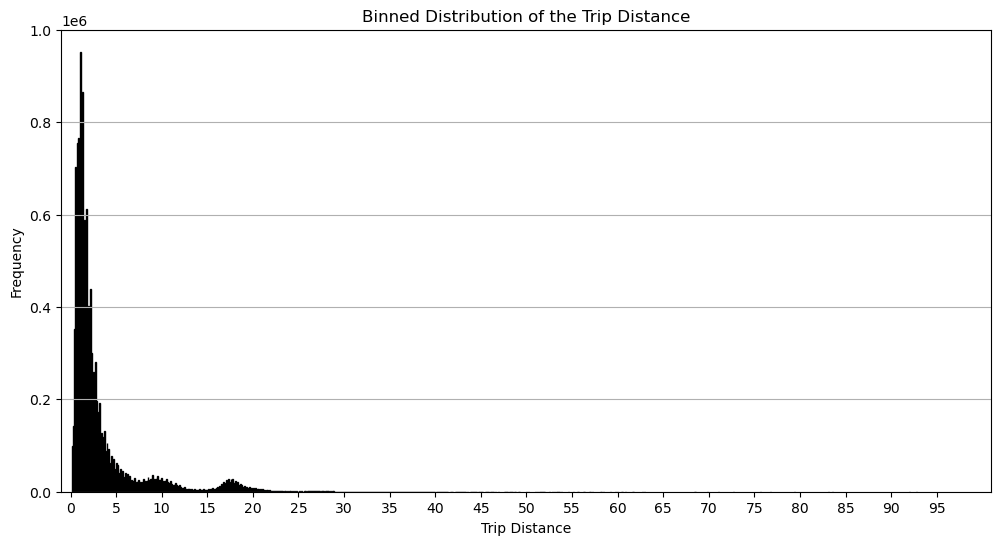

In [19]:
from pyspark.sql.functions import count, when
import matplotlib.pyplot as plt

# Define bin edges from 0 to 550 with an increment of 0.1
bin_width = 0.1
max_bin_edge = 550

# Create a column for binning
df_yellow_filtered = df_yellow_filtered.withColumn(
    'trip_distance_bin',
    (col("trip_distance") / bin_width).cast("integer") * bin_width
)

# Handle cases where cost_per_mile exceeds the max bin edge
df_yellow_filtered = df_yellow_filtered.withColumn(
    "trip_distance_bin",
    when(col("trip_distance_bin") > max_bin_edge, max_bin_edge).otherwise(col("trip_distance_bin"))
)

# Compute histogram data
histogram_data = df_yellow_filtered.groupBy("trip_distance_bin").agg(count("*").alias("frequency"))

# Convert histogram_data to Pandas DataFrame
histogram_pd = histogram_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(histogram_pd['trip_distance_bin'], histogram_pd['frequency'], width=0.1, edgecolor='black')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.title('Binned Distribution of the Trip Distance')
plt.xticks(range(0, 100, 5))  # Adjust x-ticks for readability
plt.xlim(-1, 101)  # Adjust x-axis limits if needed
plt.grid(axis='y')

# Save the plot as a PNG file
plt.savefig("../plots/histogram_trip_distance.png", bbox_inches='tight')

# Show the plot
plt.show()

In [20]:
df_yellow_filtered.count()


17364230

#### Removing trip distance less than 0.2 and above 28 miles

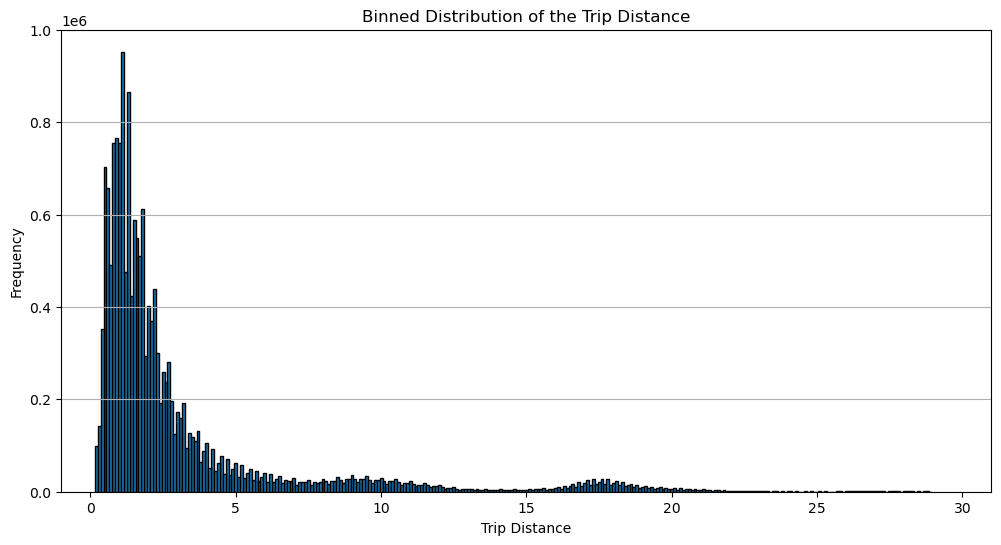

In [21]:
# Filter out rows where cost_per_mile is less than 3 or greater than 18
df_yellow_filtered = df_yellow_filtered.filter(
    (col("trip_distance") >= 0.25) & (col("trip_distance") < 29)
)
df_yellow_filtered.count()

# Define bin edges from 0 to 550 with an increment of 1
bin_width = 0.1
max_bin_edge = 550

# Create a column for binning
df_yellow_filtered = df_yellow_filtered.withColumn(
    'trip_distance_bin',
    (col("trip_distance") / bin_width).cast("integer") * bin_width
)

# Handle cases where cost_per_mile exceeds the max bin edge
df_yellow_filtered = df_yellow_filtered.withColumn(
    "trip_distance_bin",
    when(col("trip_distance_bin") > max_bin_edge, max_bin_edge).otherwise(col("trip_distance_bin"))
)

# Compute histogram data
histogram_data = df_yellow_filtered.groupBy("trip_distance_bin").agg(count("*").alias("frequency"))

# Convert histogram_data to Pandas DataFrame
histogram_pd = histogram_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(histogram_pd['trip_distance_bin'], histogram_pd['frequency'], width=0.1, edgecolor='black')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.title('Binned Distribution of the Trip Distance')
plt.xticks(range(0, 31, 5))  # Adjust x-ticks for readability
plt.xlim(-1, 31)  # Adjust x-axis limits if needed
plt.grid(axis='y')

# Save the plot as a PNG file
plt.savefig("../plots/histogram_trip_distance.png", bbox_inches='tight')

# Show the plot
plt.show()

In [22]:
df_yellow_filtered.count()

17358815

In [1]:
from pyspark.sql.functions import count, when
import matplotlib.pyplot as plt

# Define bin edges from 0 to 550 with an increment of 1
bin_width = 0.1
max_bin_edge = 1001

# Create a column for binning
df_yellow_filtered = df_yellow_filtered.withColumn(
    'fare_amount_bin',
    (col("fare_amount") / bin_width).cast("integer") * bin_width
)

# Handle cases where cost_per_mile exceeds the max bin edge
df_yellow_filtered = df_yellow_filtered.withColumn(
    "fare_amount_bin",
    when(col("fare_amount_bin") > max_bin_edge, max_bin_edge).otherwise(col("fare_amount_bin"))
)

# Compute histogram data
histogram_data = df_yellow_filtered.groupBy("fare_amount_bin").agg(count("*").alias("frequency"))

# Convert histogram_data to Pandas DataFrame
histogram_pd = histogram_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(histogram_pd['fare_amount_bin'], histogram_pd['frequency'], width=0.5, edgecolor='black')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Binned Distribution of the Fare Amount')
plt.xticks(range(0, 1000, 5))  # Adjust x-ticks for readability
plt.xlim(-1, 101)  # Adjust x-axis limits if needed
plt.grid(axis='y')

# Save the plot as a PNG file
plt.savefig("../plots/histogram_fare_amount.png", bbox_inches='tight')

# Show the plot
plt.show()

NameError: name 'df_yellow_filtered' is not defined

#### Removing Outliers

In [24]:
# Filter rows for the 70th bin (fare_amount_bin = 70.0)
df_bin_70 = df_yellow_filtered.filter((col('fare_amount_bin') >= 70) & (col('fare_amount_bin') < 70.1))
df_bin_70.count()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `fare_amount_bin` cannot be resolved. Did you mean one of the following? [`fare_amount`, `tip_amount`, `tolls_amount`, `total_amount`, `trip_distance_bin`].;
'Filter (('fare_amount_bin >= 70) AND ('fare_amount_bin < 70.1))
+- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182, CASE WHEN (trip_distance_bin#6160 > cast(550 as double)) THEN cast(550 as double) ELSE trip_distance_bin#6160 END AS trip_distance_bin#6175]
   +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182, (cast(cast((trip_distance#4169 / 0.1) as int) as double) * 0.1) AS trip_distance_bin#6160]
      +- Filter ((trip_distance#4169 >= 0.25) AND (trip_distance#4169 < cast(29 as double)))
         +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182, CASE WHEN (trip_distance_bin#6072 > cast(550 as double)) THEN cast(550 as double) ELSE trip_distance_bin#6072 END AS trip_distance_bin#6087]
            +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182, (cast(cast((trip_distance#4169 / 0.1) as int) as double) * 0.1) AS trip_distance_bin#6072]
               +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182]
                  +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182]
                     +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, improvement_surcharge#4180, total_amount#4181, congestion_surcharge#4182]
                        +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, mta_tax#4177, tip_amount#4178, tolls_amount#4179, improvement_surcharge#4180, total_amount#4181, congestion_surcharge#4182]
                           +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, mta_tax#4177, tip_amount#4178, tolls_amount#4179, improvement_surcharge#4180, total_amount#4181, congestion_surcharge#4182, Airport_fee#4183]
                              +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, RatecodeID#4170L, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, mta_tax#4177, tip_amount#4178, tolls_amount#4179, improvement_surcharge#4180, total_amount#4181, congestion_surcharge#4182, Airport_fee#4183]
                                 +- Filter NOT (PULocationID#4172 IN (264,265) OR DOLocationID#4173 IN (264,265))
                                    +- Relation [VendorID#4165,pickup_datetime#4166,dropoff_datetime#4167,passenger_count#4168L,trip_distance#4169,RatecodeID#4170L,store_and_fwd_flag#4171,PULocationID#4172,DOLocationID#4173,payment_type#4174L,fare_amount#4175,extra#4176,mta_tax#4177,tip_amount#4178,tolls_amount#4179,improvement_surcharge#4180,total_amount#4181,congestion_surcharge#4182,Airport_fee#4183] parquet


In [11]:
df_bin_70_after = df_yellow_filtered.filter((col('fare_amount_bin') > 70) & (col('fare_amount_bin') < 70.5))
df_bin_70_after.count()

5073

In [12]:

df_bin_70_after = df_yellow_filtered.filter((col('fare_amount_bin') >= 69.5) & (col('fare_amount_bin') < 70))
df_bin_70_after.count()

5155

#### Average of the next bins above it, 5073 + 5155 = 5114. We sample this many from the bin

In [23]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F

# Define bin edges and width
bin_width = 0.1
bin_target = 70.1
bin_lower_bound = bin_target - bin_width
bin_upper_bound = bin_target

# Filter rows for the 70th bin (fare_amount_bin = 70.0)
df_bin_target = df_yellow_filtered.filter((col('fare_amount_bin') >= bin_lower_bound) & (col('fare_amount_bin') < bin_upper_bound))

# Count the number of rows in this bin to ensure it is sufficient for sampling
total_rows_in_bin = df_bin_target.count()
print(f"Total rows in bin {bin_target}: {total_rows_in_bin}")

# Sample with fraction parameter to achieve the desired number of rows
fraction = 5200 / total_rows_in_bin

# Sample rows
df_bin_sampled = df_bin_target.sample(withReplacement=False, fraction=fraction)

# Ensure the sample size is exactly 5114 if there are enough rows
df_bin_sampled = df_bin_sampled.limit(5114)

# Remove original rows in the 70th bin from df_yellow_filtered
df_yellow_filtered_no_bin_70 = df_yellow_filtered.filter(
    (col('fare_amount_bin') < bin_lower_bound) | (col('fare_amount_bin') >= bin_upper_bound)
)

# Add the sampled data back to the DataFrame
df_yellow_filtered = df_yellow_filtered_no_bin_70.union(df_bin_sampled)

# Show a sample of the updated DataFrame
df_yellow_filtered.show(5)

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `fare_amount_bin` cannot be resolved. Did you mean one of the following? [`fare_amount`, `tip_amount`, `tolls_amount`, `total_amount`, `trip_distance_bin`].;
'Filter (('fare_amount_bin >= 70.0) AND ('fare_amount_bin < 70.1))
+- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182, CASE WHEN (trip_distance_bin#6160 > cast(550 as double)) THEN cast(550 as double) ELSE trip_distance_bin#6160 END AS trip_distance_bin#6175]
   +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182, (cast(cast((trip_distance#4169 / 0.1) as int) as double) * 0.1) AS trip_distance_bin#6160]
      +- Filter ((trip_distance#4169 >= 0.25) AND (trip_distance#4169 < cast(29 as double)))
         +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182, CASE WHEN (trip_distance_bin#6072 > cast(550 as double)) THEN cast(550 as double) ELSE trip_distance_bin#6072 END AS trip_distance_bin#6087]
            +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182, (cast(cast((trip_distance#4169 / 0.1) as int) as double) * 0.1) AS trip_distance_bin#6072]
               +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182]
                  +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, total_amount#4181, congestion_surcharge#4182]
                     +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, tip_amount#4178, tolls_amount#4179, improvement_surcharge#4180, total_amount#4181, congestion_surcharge#4182]
                        +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, mta_tax#4177, tip_amount#4178, tolls_amount#4179, improvement_surcharge#4180, total_amount#4181, congestion_surcharge#4182]
                           +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, mta_tax#4177, tip_amount#4178, tolls_amount#4179, improvement_surcharge#4180, total_amount#4181, congestion_surcharge#4182, Airport_fee#4183]
                              +- Project [pickup_datetime#4166, dropoff_datetime#4167, passenger_count#4168L, trip_distance#4169, RatecodeID#4170L, store_and_fwd_flag#4171, PULocationID#4172, DOLocationID#4173, payment_type#4174L, fare_amount#4175, extra#4176, mta_tax#4177, tip_amount#4178, tolls_amount#4179, improvement_surcharge#4180, total_amount#4181, congestion_surcharge#4182, Airport_fee#4183]
                                 +- Filter NOT (PULocationID#4172 IN (264,265) OR DOLocationID#4173 IN (264,265))
                                    +- Relation [VendorID#4165,pickup_datetime#4166,dropoff_datetime#4167,passenger_count#4168L,trip_distance#4169,RatecodeID#4170L,store_and_fwd_flag#4171,PULocationID#4172,DOLocationID#4173,payment_type#4174L,fare_amount#4175,extra#4176,mta_tax#4177,tip_amount#4178,tolls_amount#4179,improvement_surcharge#4180,total_amount#4181,congestion_surcharge#4182,Airport_fee#4183] parquet


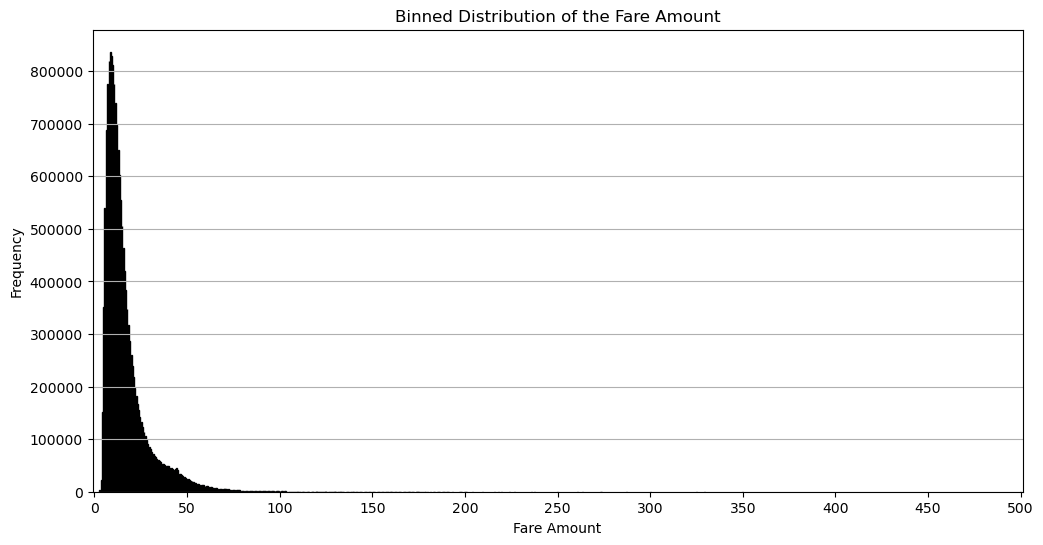

In [14]:
# Define bin edges from 0 to 550 with an increment of 1
bin_width = 0.1
max_bin_edge = 1001

# Create a column for binning
df_yellow_filtered = df_yellow_filtered.withColumn(
    'fare_amount_bin',
    (col("fare_amount") / bin_width).cast("integer") * bin_width
)

# Handle cases where cost_per_mile exceeds the max bin edge
df_yellow_filtered = df_yellow_filtered.withColumn(
    "fare_amount_bin",
    when(col("fare_amount_bin") > max_bin_edge, max_bin_edge).otherwise(col("fare_amount_bin"))
)

# Compute histogram data
histogram_data = df_yellow_filtered.groupBy("fare_amount_bin").agg(count("*").alias("frequency"))

# Convert histogram_data to Pandas DataFrame
histogram_pd = histogram_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(histogram_pd['fare_amount_bin'], histogram_pd['frequency'], width=0.5, edgecolor='black')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Binned Distribution of the Fare Amount')
plt.xticks(range(0, 1000, 50))  # Adjust x-ticks for readability
plt.xlim(-1, 501)  # Adjust x-axis limits if needed
plt.grid(axis='y')

# Save the plot as a PNG file
plt.savefig("../plots/histogram_fare_amount.png", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
df_yellow_filtered.count()

In [15]:
df_yellow_filtered.describe(['trip_distance', 
                    'fare_amount', 
                    'total_amount', 
                    'passenger_count', 
                    'extra', 
                    'tip_amount', 
                    'tolls_amount', 
                    'congestion_surcharge']).show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+
|summary|     trip_distance|       fare_amount|      total_amount|  passenger_count|             extra|        tip_amount|      tolls_amount|congestion_surcharge|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+
|  count|          16742502|          16742502|          16742502|         16742502|          16742502|          16742502|          16742502|            16742502|
|   mean|2.6503742726144557|16.545686700833116|25.139468992762424|1.338688327467424|1.6128224891357352| 3.270593660374014|0.3136236364192685|  2.3750696431154674|
| stddev| 2.951207143140774|12.027587475593693|   15.733945625178|0.846221211946608|1.8017579175192127|3.1621689518834746|1.5320112023696522|  0.5447184937829744|
|    min|             

# Tip Amount disb

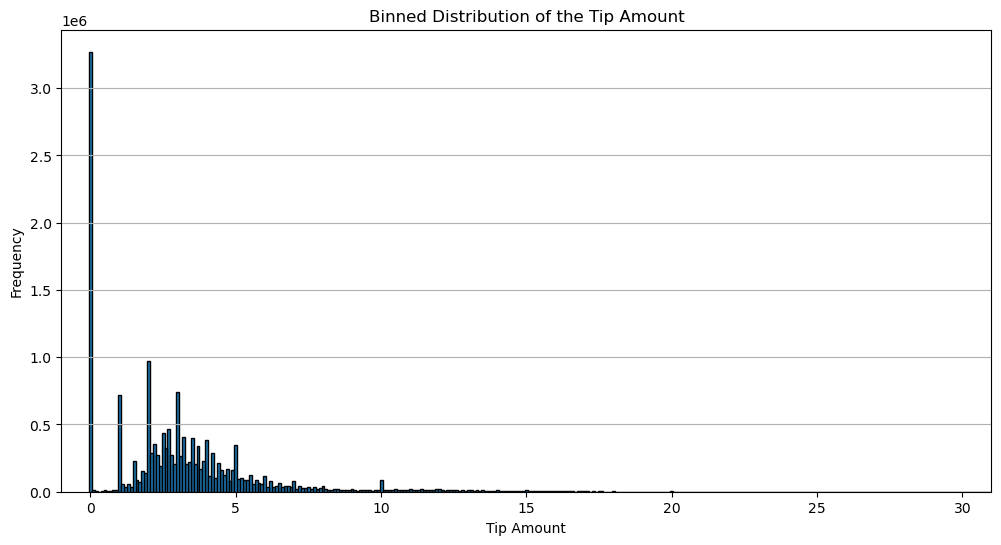

In [16]:
# Define bin edges from 0 to 550 with an increment of 1
bin_width = 0.1
max_bin_edge = 550

# Create a column for binning
df_yellow_filtered = df_yellow_filtered.withColumn(
    'tip_amount_bin',
    (col("tip_amount") / bin_width).cast("integer") * bin_width
)

# Handle cases where cost_per_mile exceeds the max bin edge
df_yellow_filtered = df_yellow_filtered.withColumn(
    "tip_amount_bin",
    when(col("tip_amount_bin") > max_bin_edge, max_bin_edge).otherwise(col("tip_amount_bin"))
)

# Compute histogram data
histogram_data = df_yellow_filtered.groupBy("tip_amount_bin").agg(count("*").alias("frequency"))

# Convert histogram_data to Pandas DataFrame
histogram_pd = histogram_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(histogram_pd['tip_amount_bin'], histogram_pd['frequency'], width=0.1, edgecolor='black')
plt.xlabel('Tip Amount')
plt.ylabel('Frequency')
plt.title('Binned Distribution of the Tip Amount')
plt.xticks(range(0, 31, 5))  # Adjust x-ticks for readability
plt.xlim(-1, 31)  # Adjust x-axis limits if needed
plt.grid(axis='y')

# Save the plot as a PNG file
plt.savefig("../plots/histogram_tip_amount.png", bbox_inches='tight')

# Show the plot
plt.show()

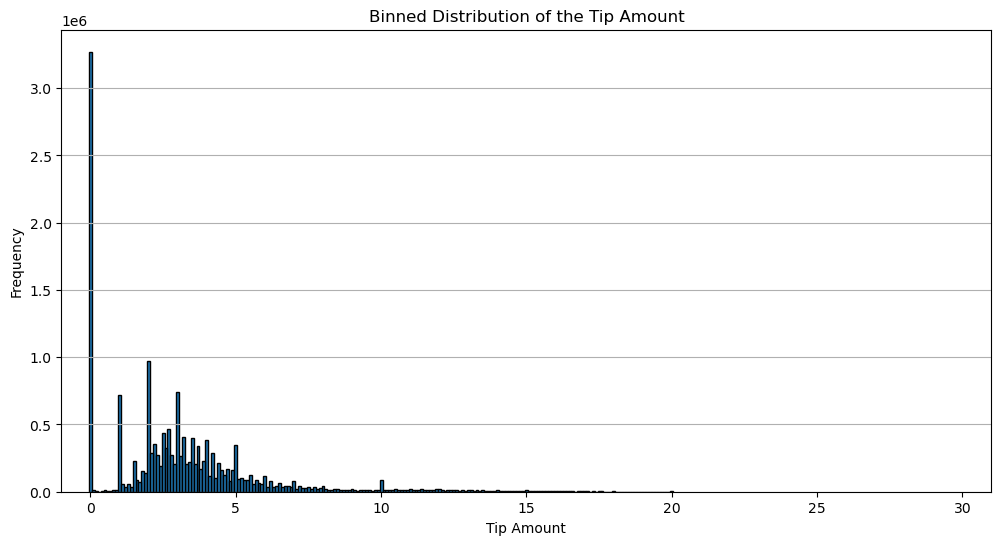

In [17]:
# Filter out rows where cost_per_mile is less than 3 or greater than 18
df_yellow_filtered = df_yellow_filtered.filter(
    (col("tip_amount") <= 20)
)
# Define bin edges from 0 to 550 with an increment of 1
bin_width = 0.1
max_bin_edge = 550

# Create a column for binning
df_yellow_filtered = df_yellow_filtered.withColumn(
    'tip_amount_bin',
    (col("tip_amount") / bin_width).cast("integer") * bin_width
)

# Handle cases where cost_per_mile exceeds the max bin edge
df_yellow_filtered = df_yellow_filtered.withColumn(
    "tip_amount_bin",
    when(col("tip_amount_bin") > max_bin_edge, max_bin_edge).otherwise(col("tip_amount_bin"))
)

# Compute histogram data
histogram_data = df_yellow_filtered.groupBy("tip_amount_bin").agg(count("*").alias("frequency"))

# Convert histogram_data to Pandas DataFrame
histogram_pd = histogram_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(histogram_pd['tip_amount_bin'], histogram_pd['frequency'], width=0.1, edgecolor='black')
plt.xlabel('Tip Amount')
plt.ylabel('Frequency')
plt.title('Binned Distribution of the Tip Amount')
plt.xticks(range(0, 31, 5))  # Adjust x-ticks for readability
plt.xlim(-1, 31)  # Adjust x-axis limits if needed
plt.grid(axis='y')

# Save the plot as a PNG file
plt.savefig("../plots/histogram_tip_amount.png", bbox_inches='tight')

# Show the plot
plt.show()

In [18]:
df_yellow_filtered.describe(['trip_distance', 
                    'fare_amount', 
                    'total_amount', 
                    'passenger_count', 
                    'extra', 
                    'tip_amount', 
                    'tolls_amount', 
                    'congestion_surcharge']).show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+
|summary|     trip_distance|       fare_amount|      total_amount|   passenger_count|             extra|        tip_amount|       tolls_amount|congestion_surcharge|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+
|  count|          16716836|          16716836|          16716836|          16716836|          16716836|          16716836|           16716836|            16716836|
|   mean|2.6310573077343187|16.468579799435222|25.018260418435045|1.3386424919165325|1.6109734407874807|3.2335766122249234|0.30861432330839955|  2.3764080266146057|
| stddev| 2.894452129280527|11.817562174095038|  15.3925269885995|0.8461980711846949|1.7990818834690516|2.9342891463130885| 1.5165647137643141|  0.5419454738568606|
|    min| 

# Cost Per Mile

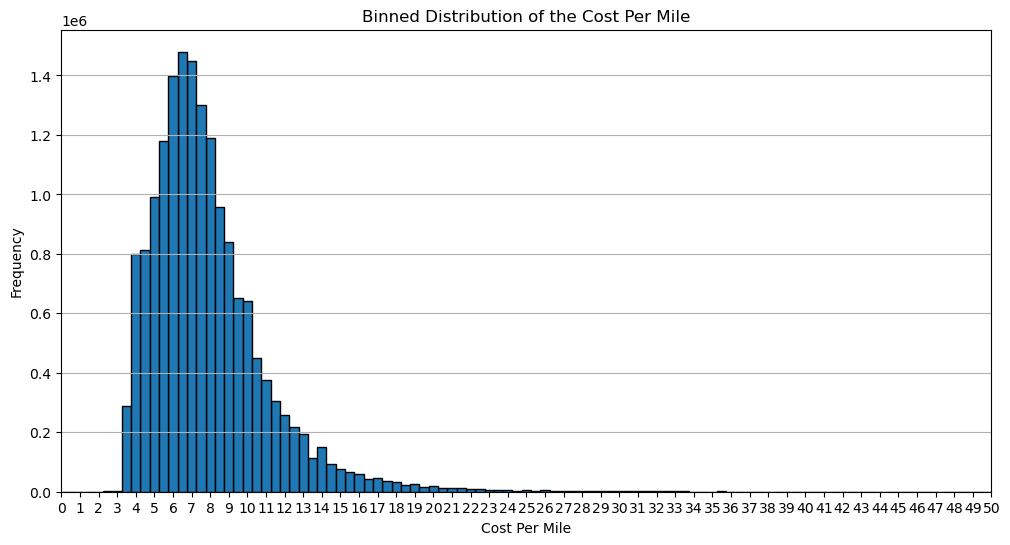

In [19]:
from pyspark.sql.functions import count, when
import matplotlib.pyplot as plt

# Calculate cost per mile
df_yellow_filtered = df_yellow_filtered.withColumn(
    "cost_per_mile",
    col("fare_amount") / col("trip_distance")
)

# Define bin edges from 0 to 550 with an increment of 1
bin_width = 0.5
max_bin_edge = 550

# Create a column for binning
df_yellow_filtered = df_yellow_filtered.withColumn(
    "cost_per_mile_bin",
    (col("cost_per_mile") / bin_width).cast("integer") * bin_width
)

# Handle cases where cost_per_mile exceeds the max bin edge
df_yellow_filtered = df_yellow_filtered.withColumn(
    "cost_per_mile_bin",
    when(col("cost_per_mile_bin") > max_bin_edge, max_bin_edge).otherwise(col("cost_per_mile_bin"))
)

# Compute histogram data
histogram_data = df_yellow_filtered.groupBy("cost_per_mile_bin").agg(count("*").alias("frequency"))

# Convert histogram_data to Pandas DataFrame
histogram_pd = histogram_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(histogram_pd['cost_per_mile_bin'], histogram_pd['frequency'], width=0.5, edgecolor='black')
plt.xlabel('Cost Per Mile')
plt.ylabel('Frequency')
plt.title('Binned Distribution of the Cost Per Mile')
plt.xticks(range(0, 51, 1))  # Adjust x-ticks for readability
plt.xlim(0, 50)  # Adjust x-axis limits if needed
plt.grid(axis='y')

# Save the plot as a PNG file
plt.savefig("../plots/histogram_cost_per_mile.png", bbox_inches='tight')

# Show the plot
plt.show()

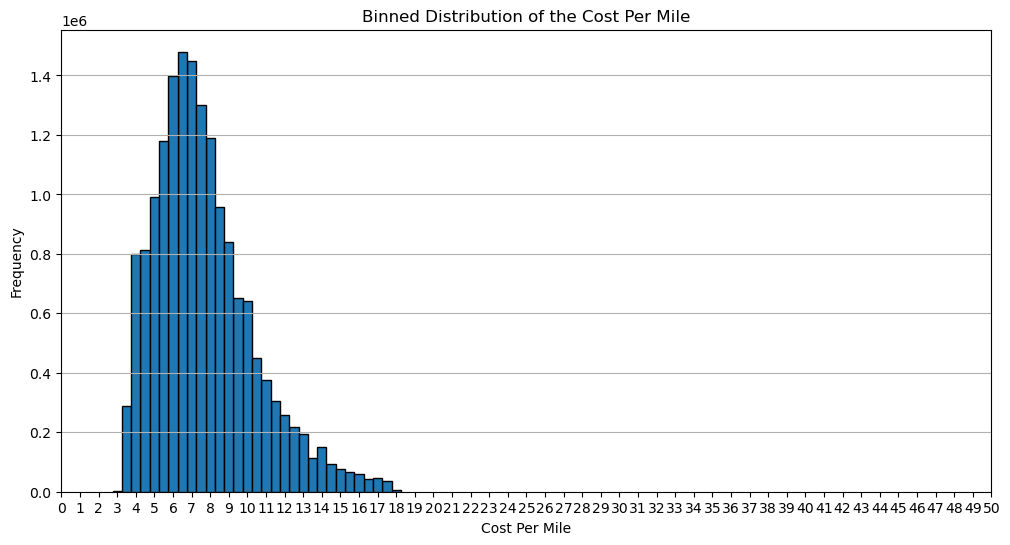

In [20]:
# Filter out rows where cost_per_mile is less than 3 or greater than 18
df_yellow_filtered = df_yellow_filtered.filter(
    (col("cost_per_mile") > 3) & (col("cost_per_mile") <= 18)
)

# Compute histogram data
histogram_data = df_yellow_filtered.groupBy("cost_per_mile_bin").agg(count("*").alias("frequency"))

# Convert histogram_data to Pandas DataFrame
histogram_pd = histogram_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(histogram_pd['cost_per_mile_bin'], histogram_pd['frequency'], width=0.5, edgecolor='black')
plt.xlabel('Cost Per Mile')
plt.ylabel('Frequency')
plt.title('Binned Distribution of the Cost Per Mile')
plt.xticks(range(0, 51, 1)) # Adjust x-ticks for readability
plt.xlim(0, 50) # Adjust x-axis limits if needed
plt.grid(axis='y')

# Save the plot as a PNG file
plt.savefig("../plots/histogram_cost_per_mile_cropped.png", bbox_inches='tight')

# Show the plot
plt.show()
df_yellow_filtered = df_yellow_filtered.drop('cost_per_mile', 'cost_per_mile_bin')

In [21]:
df_yellow_filtered.describe(['trip_distance', 
                    'fare_amount', 
                    'total_amount', 
                    'passenger_count', 
                    'extra',  
                    'tip_amount', 
                    'tolls_amount',  
                    'congestion_surcharge' ]).show()
df_yellow_filtered.show(1)

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+
|summary|     trip_distance|       fare_amount|      total_amount|   passenger_count|             extra|        tip_amount|       tolls_amount|congestion_surcharge|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+
|  count|          16476972|          16476972|          16476972|          16476972|          16476972|          16476972|           16476972|            16476972|
|   mean|  2.65878917497695|16.500919421363573| 25.06951515425744|1.3381492060555786|1.6154842012233817| 3.243314552576756|0.31280149046787986|    2.37509567898762|
| stddev|2.9031052279200478|11.854959328527661|15.451922872279642|0.8460412395226226|1.8024539288195705|2.9410075371063815| 1.5261760299017153|  0.5446647878538639|
|    min| 

+-------------------+-------------------+---------------+-------------+------------+------------+------------+-----------+-----+----------+------------+------------+--------------------+-----------------+---------------+--------------+
|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|congestion_surcharge|trip_distance_bin|fare_amount_bin|tip_amount_bin|
+-------------------+-------------------+---------------+-------------+------------+------------+------------+-----------+-----+----------+------------+------------+--------------------+-----------------+---------------+--------------+
|2023-12-09T20:23:14|2023-12-09T20:41:22|              1|         1.31|          48|         237|           1|       16.3|  1.0|       2.0|         0.0|        23.3|                 2.5|              1.3|           16.3|           2.0|
+-------------------+-------------------+---------------

In [22]:
df_yellow_filtered.write.mode('overwrite').parquet('../data/Curated Layer/yellow_curated.parquet')

24/08/30 16:58:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/30 16:58:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


### To do list
#### Cut off outliers based on graph
#### Use geopandas to plot cool graphs for taxi and parking data
#### Some ideas: Heat map of pick up destinations and drop offs
#### Heatmap of parking fines

## Development Layer

In [23]:
df_yellow_taxi = spark.read.parquet('../data/Curated Layer/yellow_curated.parquet')

In [24]:
from pyspark.sql.functions import col

# Calculate the cost per mile
df_yellow_taxi = df_yellow_taxi.withColumn("cost_per_mile", col("fare_amount") / col("trip_distance"))

In [25]:
from pyspark.sql.functions import date_format, hour

# Assuming you have a 'pickup_datetime' column
df_yellow_taxi = df_yellow_taxi.withColumn("day_of_week", date_format(col("pickup_datetime"), "E"))  # 'E' gives Mon, Tue, etc.
df_yellow_taxi = df_yellow_taxi.withColumn("hour_of_day", hour(col("pickup_datetime")))  # Extract hour (0-23)

In [26]:
# Group by day_of_week and hour_of_day, and calculate the average cost_per_mile
avg_cost_df = df_yellow_taxi.groupBy("day_of_week", "hour_of_day") \
    .agg({"cost_per_mile": "avg"}) \
    .withColumnRenamed("avg(cost_per_mile)", "avg_cost_per_mile")

# Collect the results as a Pandas DataFrame
avg_cost_pandas_df = avg_cost_df.toPandas()

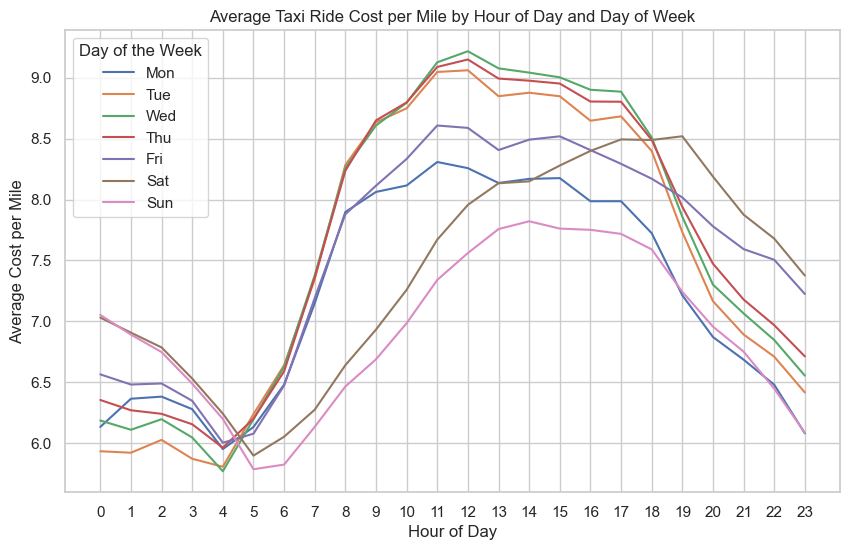

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize a seaborn style plot
sns.set(style="whitegrid")

# Define the custom order for the days of the week
days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Ensure 'day_of_week' is treated as a categorical variable with the correct order
avg_cost_pandas_df['day_of_week'] = pd.Categorical(avg_cost_pandas_df['day_of_week'], categories=days_order, ordered=True)

# Create a pivot table to have hours as index and days as columns
pivot_df = avg_cost_pandas_df.pivot(index="hour_of_day", columns="day_of_week", values="avg_cost_per_mile")

# Plot the results
plt.figure(figsize=(10, 6))
for day in days_order:
    plt.plot(pivot_df.index, pivot_df[day], label=day)

plt.title('Average Taxi Ride Cost per Mile by Hour of Day and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Cost per Mile')
plt.legend(title="Day of the Week")
plt.xticks(range(0, 24))  # Show every hour on the x-axis
plt.show()

In [28]:
df_yellow_taxi.show(1)


+-------------------+-------------------+---------------+-------------+------------+------------+------------+-----------+-----+----------+------------+------------+--------------------+-----------------+---------------+--------------+-----------------+-----------+-----------+
|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|congestion_surcharge|trip_distance_bin|fare_amount_bin|tip_amount_bin|    cost_per_mile|day_of_week|hour_of_day|
+-------------------+-------------------+---------------+-------------+------------+------------+------------+-----------+-----+----------+------------+------------+--------------------+-----------------+---------------+--------------+-----------------+-----------+-----------+
|2024-02-11T15:01:29|2024-02-11T15:17:11|              1|         2.65|         170|         262|           1|       16.3|  0.0|      4.06|         0.0|       24.36| 

In [29]:
mapping_df = spark.read.csv("../data/taxi_zone_precinct_mapping.csv", header=True, inferSchema=True)

# Rename 'LocationID' in the mapping dataset to 'PULocationID' for the join
mapping_df = mapping_df.withColumnRenamed("LocationID", "PULocationID")

# Perform the join on PULocationID to add the 'precinct' column to the taxi dataset
taxi_with_precinct_df = df_yellow_taxi.join(mapping_df, on="PULocationID", how="left")

# Show the result with the new 'precinct' column
taxi_with_precinct_df.show(10)


+------------+-------------------+-------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+------------+--------------------+------------------+------------------+------------------+-----------------+-----------+-----------+--------+
|PULocationID|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|DOLocationID|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|congestion_surcharge| trip_distance_bin|   fare_amount_bin|    tip_amount_bin|    cost_per_mile|day_of_week|hour_of_day|precinct|
+------------+-------------------+-------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+------------+--------------------+------------------+------------------+------------------+-----------------+-----------+-----------+--------+
|         170|2024-02-11T15:01:29|2024-02-11T15:17:11|              1|         2.65|         262|           1|     

In [30]:
taxi_with_precinct_df.write.mode('overwrite').parquet('../data/Development Layer/yellow_taxi.parquet')

24/08/30 16:58:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/30 16:59:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
